# Perder hasta la camisa

### Autor: Mario Fernández Simón

In [150]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#!pip install apafib --upgrade --user --quiet
#%pip install scikit-optimize

In [151]:
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
import skopt
from skopt import BayesSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from yellowbrick.classifier.rocauc import roc_auc
import importlib
importlib.reload(skopt)

<module 'skopt' from '/home/mario/.local/lib/python3.10/site-packages/skopt/__init__.py'>

In [189]:
def save_results(clf, X_test, y_test, nclf, df):
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (W)'] = precision_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'recall score (W)'] = recall_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'f1 score (W)'] = f1_score(y_test, clf.predict(X_test), average='weighted')
    return df

results_df = pd.DataFrame()

# Apartado: A

En primer lugar haremos un pequeño estudio de los datos y los representaremos.

In [153]:
# Cargamos los datos y los visualizamos
from apafib import load_NASDAQ

data = load_NASDAQ()
data.head()

,GOOGLE-P,GOOGLE-V,GOOGLE-GAP,MSFT-P,MSFT-V,MSFT-GAP,AAPL-P,AAPL-V,AAPL-GAP,INTEL-P,INTEL-V,INTEL-GAP,AMD-P,AMD-V,AMD-GAP
0,45.3330,18846560,0.4800,72.15,17698800,0.78,39.3025,105320280,0.6950,34.92,26479700,0.58,12.05,58786300,0.560
1,46.2345,23326400,0.7192,73.16,14333220,0.89,39.9450,86259560,0.4950,34.65,26093400,0.57,12.17,38946780,0.230
2,46.3500,21771500,0.5285,72.72,13758650,0.62,39.9950,77507760,0.3975,34.66,19775620,0.43,12.48,44193270,0.585
3,46.0640,25323820,0.7670,72.69,17097240,0.79,39.8175,79128680,0.5475,34.71,14283180,0.34,12.50,37161680,0.320
4,45.7945,21055280,0.5027,72.82,12790300,0.87,39.9650,100738400,0.3225,34.67,14714810,0.35,12.43,29650370,0.320


Delante tenemos unos datos extraidos del NASDAQ, en el vemos la vida de las acciones de grandes empresas tecnologicas. Cada empresa tiene 3 caracteristicas particulares de sus acciones, el precio, el volumen y GAP que es la diferencia entre el mayor y el menor precio.

In [154]:
# Seguimos visuzalizando
data.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
GOOGLE-P,1259.0,8.235332e+01,3.232053e+01,4.533300e+01,5.610350e+01,6.736500e+01,1.129415e+02,1.507090e+02
GOOGLE-V,1259.0,3.091715e+07,1.347789e+07,6.935060e+06,2.256946e+07,2.773012e+07,3.531136e+07,1.238938e+08
GOOGLE-GAP,1259.0,1.740178e+00,1.209965e+00,2.380000e-01,8.713000e-01,1.371000e+00,2.218750e+00,9.215500e+00
MSFT-P,1259.0,1.818206e+02,7.862105e+01,7.215000e+01,1.081500e+02,1.634900e+02,2.524850e+02,3.431100e+02
MSFT-V,1259.0,2.953929e+07,1.299424e+07,7.425603e+06,2.125149e+07,2.629290e+07,3.374066e+07,1.109450e+08
MSFT-GAP,1259.0,3.812815e+00,2.912805e+00,3.400000e-01,1.660000e+00,3.060000e+00,5.141250e+00,2.364000e+01
AAPL-P,1259.0,9.035068e+01,4.626909e+01,3.554750e+01,4.748250e+01,7.193250e+01,1.336400e+02,1.820100e+02
AAPL-V,1259.0,1.184749e+08,5.504025e+07,4.099995e+07,8.193916e+07,1.042700e+08,1.382814e+08,4.268848e+08
AAPL-GAP,1259.0,2.068242e+00,1.694044e+00,2.135000e-01,7.762500e-01,1.502500e+00,2.925000e+00,1.281000e+01
INTEL-P,1259.0,5.089460e+01,6.684044e+00,3.452000e+01,4.672000e+01,5.059000e+01,5.538000e+01,6.847000e+01


Pese que al visualizar los datos ya parecía que no había valores perdidos, lo comprobaremos explícitamente.

In [155]:
data.isna().sum()

GOOGLE-P      0
GOOGLE-V      0
GOOGLE-GAP    0
MSFT-P        0
MSFT-V        0
MSFT-GAP      0
AAPL-P        0
AAPL-V        0
AAPL-GAP      0
INTEL-P       0
INTEL-V       0
INTEL-GAP     0
AMD-P         0
AMD-V         0
AMD-GAP       0
dtype: int64

A continuación, calculamos la correlación que existe entre las variables.

(<Figure size 1100x1100 with 1 Axes>, <Axes: >)

<Axes: >

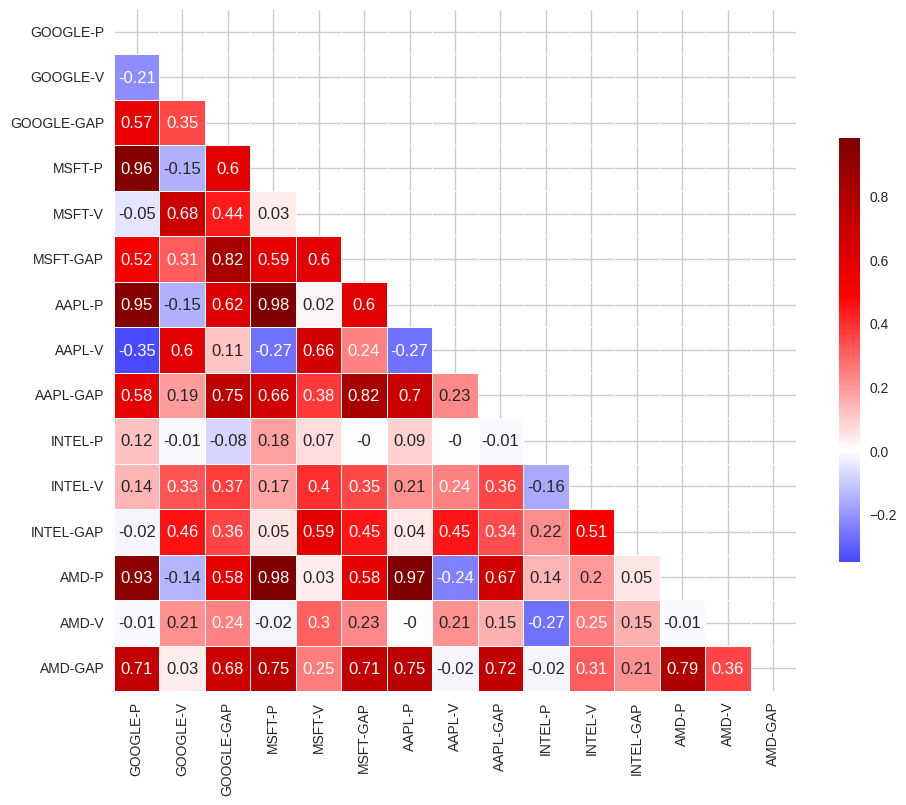

In [156]:
variablesFrame = pd.DataFrame(data)
correlacion = variablesFrame.corr().round(2)
mask = np.triu(np.ones_like(correlacion, dtype=bool))
plt.subplots(figsize=(11, 11))
sns.heatmap(correlacion, mask=mask, cmap='seismic', annot = True, square=True, center=0, linewidths = .5, cbar_kws={"shrink": .5})

A simple vista se observa como las variables P de todas menos la de Intel están fuertemente relacionadas.Para GAP y V también parece haber una relación entre ellas pero no tan exagerada como para P.

Esto ya puede darnos indicios que las variables P puede que sea posible predecirlas usando otras variables P. Para acabar de confirmar o descartar nuestros indicios, miraremos como evolucionan las variables temporalmente.

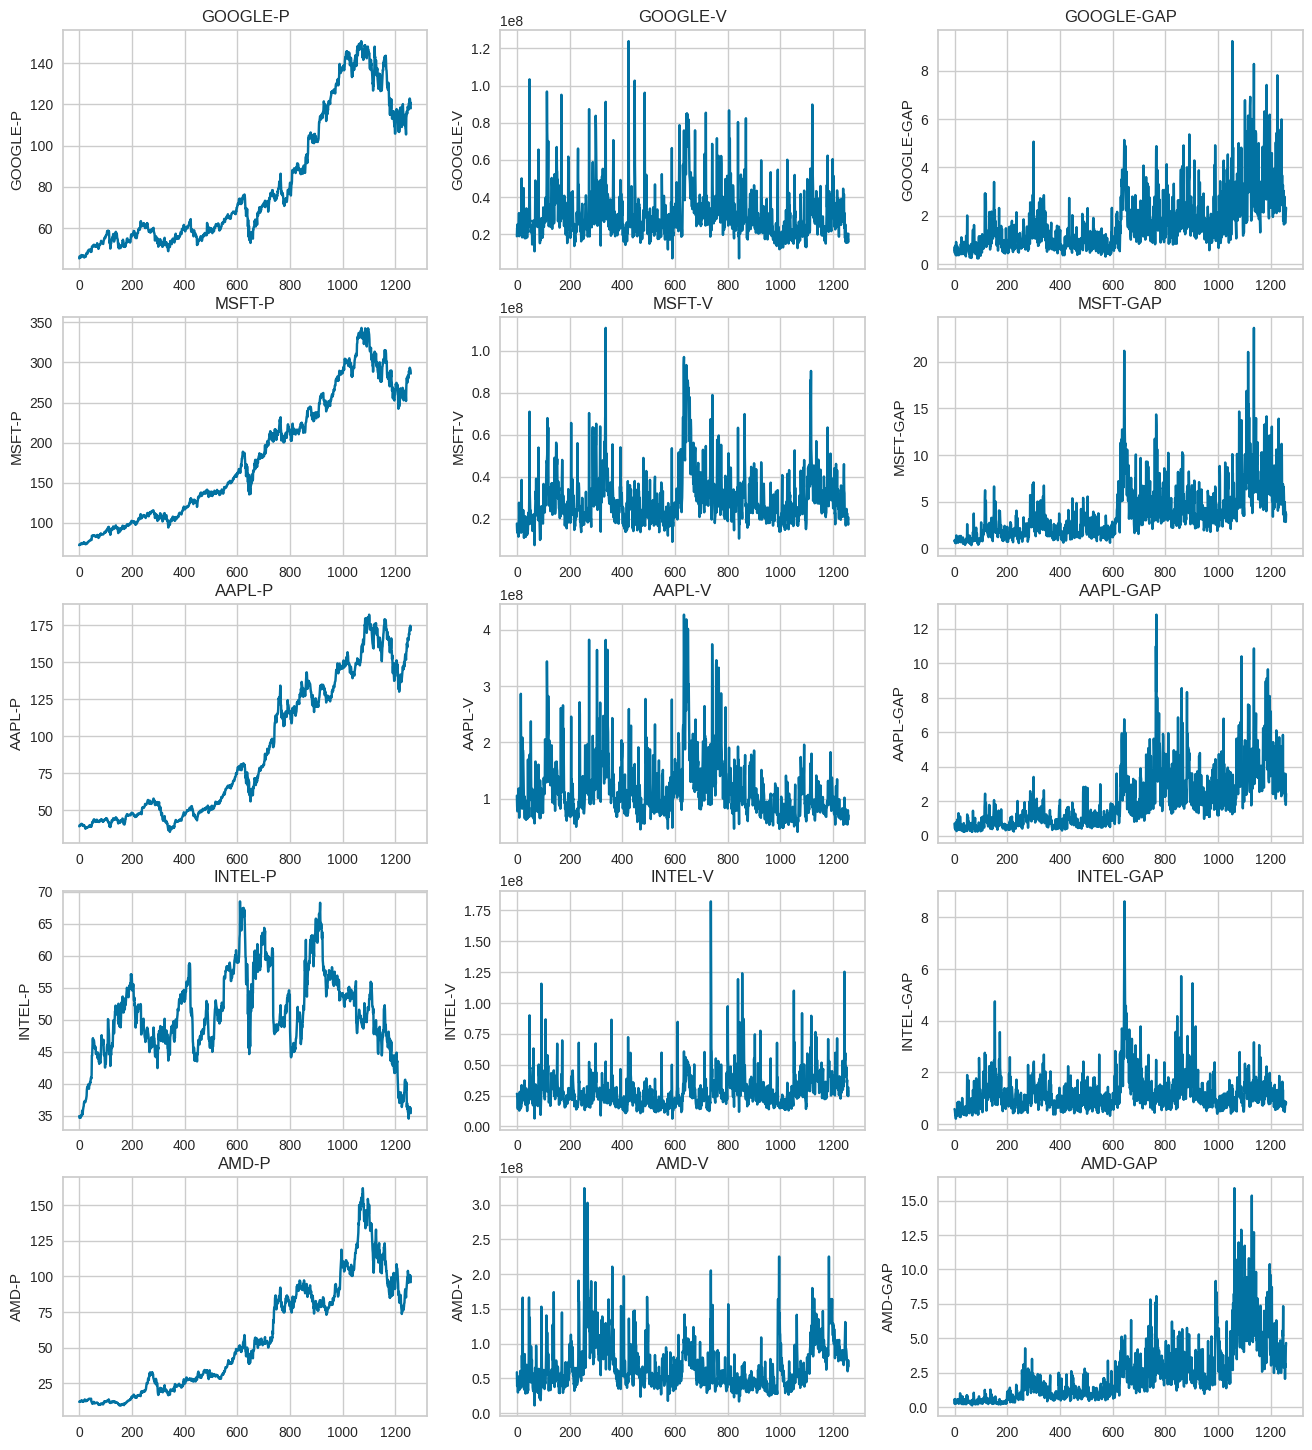

In [157]:
fig, axes = plt.subplots(5,3,figsize=(16,18));

for i, j in enumerate(data.columns):
    ax = axes.reshape(-1)[i];
    a = sns.lineplot(x=list(range(len(data))), y = data[j], data=data, ax=ax);
    t = ax.set_title(j);

Como sospechabamos de antes, vemos como la variable P puede ser predecida utilizando los valores de las demás, excepto para Intel. 

Por otro lado, pese a que las variables GAP y V entre compañías siguen una evolución parecida, no es buena idea intentar predecirlas debido a los cambios tan bruscos entre altos y bajos que hace. 

A continuación, normalizaremos los datos y haremos la partición. La partición será un poco diferente que la de otras prácticas, ya que usaremos los primeros 1000 dias como datos de entrenamiento y el resto como de test.

In [158]:

from sklearn.preprocessing import MinMaxScaler

train = data[:1000]
test = data[1000:]

# NOrmalizar [0, 1]
scaler = MinMaxScaler()

trainScale = pd.DataFrame(scaler.fit_transform(train))
testScale = pd.DataFrame(scaler.transform(test))

trainScale.describe(include="all").T
testScale.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
0,1000.0,0.256617,0.230343,0.0,0.101405,0.160291,0.321931,1.0
1,1000.0,0.213752,0.119506,0.0,0.142255,0.181653,0.252428,1.0
2,1000.0,0.222284,0.162102,0.0,0.104573,0.180349,0.292293,1.0
3,1000.0,0.369184,0.269138,0.0,0.147044,0.298961,0.620483,1.0
4,1000.0,0.213220,0.130077,0.0,0.130687,0.179266,0.252860,1.0
5,1000.0,0.129592,0.109012,0.0,0.053263,0.098848,0.172061,1.0
6,1000.0,0.329274,0.302723,0.0,0.081490,0.173005,0.653303,1.0
7,1000.0,0.212309,0.151206,0.0,0.110523,0.173224,0.272537,1.0
8,1000.0,0.112148,0.110666,0.0,0.036191,0.074941,0.151054,1.0
9,1000.0,0.507445,0.194408,0.0,0.367238,0.489208,0.655973,1.0


,count,mean,std,min,25%,50%,75%,max
0,259.0,0.917304,0.138380,0.637324,0.772408,0.965868,1.032562,1.117319
1,259.0,0.171438,0.089566,0.047265,0.105484,0.151974,0.213950,0.708076
2,259.0,0.567395,0.274564,0.084147,0.365092,0.530867,0.706121,1.752733
3,259.0,1.025429,0.114615,0.782043,0.948465,1.025515,1.092382,1.245679
4,259.0,0.215159,0.106345,0.063083,0.143261,0.199786,0.262490,0.801813
5,259.0,0.309693,0.152895,0.083493,0.193313,0.278311,0.389515,1.118042
6,259.0,1.073677,0.110269,0.831958,0.989349,1.067252,1.172355,1.289254
7,259.0,0.110923,0.069294,-0.011662,0.061936,0.097157,0.142215,0.394496
8,259.0,0.282743,0.132520,0.076283,0.189854,0.260906,0.351010,0.844401
9,259.0,0.375617,0.173937,-0.003844,0.263454,0.406268,0.514193,0.631283


El siguiente paso será generar la variable objetivo para asignar las ventanas.

In [159]:
Google_P = data["GOOGLE-P"].values
predictor = [0]

for i in range(1, len(Google_P)):
    predictor.append(int(Google_P[i] > Google_P[i-1]))

A continuación, creamos ventanas de tamaño 3.

In [160]:
# size de la windows
w = 3

predictorTra = predictor[w:1000]
predictorTes  = predictor[1000+w:]

# Hacemos las ventanas
windowsTrai = sliding_window_view(trainScale, w+1, axis=0).copy()
windowTrainX, windowTrainY = windowsTrai.squeeze()[:,:,:-1].reshape((-1, len(testScale.columns)*w)),  np.array(predictorTra)

windowsTest = sliding_window_view(testScale, w+1, axis=0).copy()
windowTestX, windowTestY = windowsTest.squeeze()[:,:,:-1].reshape((-1, len(testScale.columns)*w)),  np.array(predictorTes)

windowTrainX.shape, windowTrainY.shape, windowTestX.shape, windowTestY.shape

((997, 45), (997,), (256, 45), (256,))

En estas ventanas de 3 encontramos que los datos que eran consecutivos lo siguen siendo.

# Apartado B: clasificación logísitica

In [161]:
lrc = LogisticRegression(max_iter=10000)
print("CrossValScore:", np.mean(cross_val_score(lrc, windowTrainX, windowTrainY, cv=TimeSeriesSplit(n_splits=10, gap=w+1))))

CrossValScore: 0.518888888888889


Vemos que el valor de la validación cruzada es bastante bajo, a priori, podía ser difícil de intuir debido a la alta correlación que había en las variables. Seguiremos el estudio con una búsqueda Bayesiana. 

In [162]:
param = {'penalty':['none', 'l2'], 'C':10**np.linspace(-3,3,20, endpoint=True)}

lrcBayes =  BayesSearchCV(lrc, param, n_iter=15, cv=TimeSeriesSplit(n_splits=10, gap=w+1), n_jobs=-1, refit=True, random_state = 0);
lrcBayes.fit(windowTrainX, y=windowTrainY);

show_html(pd.DataFrame(lrcBayes.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

/home/mario/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/mario/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mario/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/mario/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mario/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

BayesSearchCV(cv=TimeSeriesSplit(gap=4, max_train_size=None, n_splits=10, test_size=None),
              estimator=LogisticRegression(max_iter=10000), n_iter=15,
              n_jobs=-1, random_state=0,
              search_spaces={'C': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03]),
                             'penalty': ['none', 'l2']})

,params,mean_test_score,rank_test_score
14,"{'C': 0.0379269019073225, 'penalty': 'l2'}",0.558889,1
4,"{'C': 0.018329807108324356, 'penalty': 'l2'}",0.553333,2
12,"{'C': 0.018329807108324356, 'penalty': 'l2'}",0.553333,2
9,"{'C': 0.1623776739188721, 'penalty': 'l2'}",0.548889,4
0,"{'C': 1.438449888287663, 'penalty': 'none'}",0.525556,5


Al explorar con distintos parámetros vemos como no hay una mejora significativa. Seguiremos explorando el modelo para ver que da los problemas.

In [190]:
print(classification_report(lrcBayes.predict(windowTestX), windowTestY, target_names=["Decreases", "Increases"]))
results_df = save_results(lrcBayes, windowTestX, windowTestY, 'Logistic Apartado B', results_df)

              precision    recall  f1-score   support

   Decreases       0.00      0.00      0.00         0
   Increases       1.00      0.52      0.68       256

    accuracy                           0.52       256
   macro avg       0.50      0.26      0.34       256
weighted avg       1.00      0.52      0.68       256



/home/mario/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mario/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mario/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mario/.local/lib/python3.10/site-packages/sklearn/metrics/

Vemos que está sucediendo algo curioso. El modelo está prediciendo todos los valores como más altos. Una explicación que se puede atribuir a este suceso es que como se ha visto en las gráficas, los valores incrementaban conforme pasaba el tiempo y crecían drásticamente hacia el final. Con lo cual, los últimos datos(que acaban siendo los de test) se detectan como valores muy altos y por encima de la media y esto produce ese comportamiento.

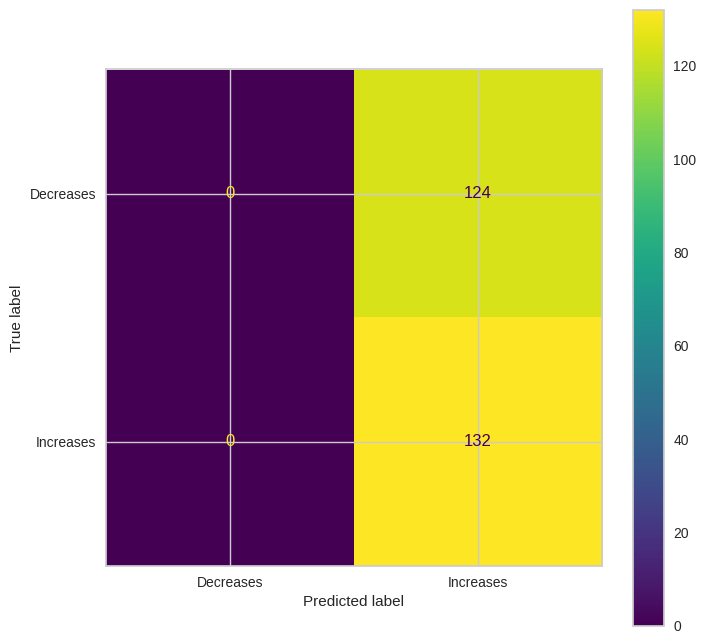

In [164]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lrcBayes, windowTestX, windowTestY, display_labels=["Decreases", "Increases"], ax=plt.subplot());

La matriz vuelve a confirmarnos lo que hemos explicada anteriormente.

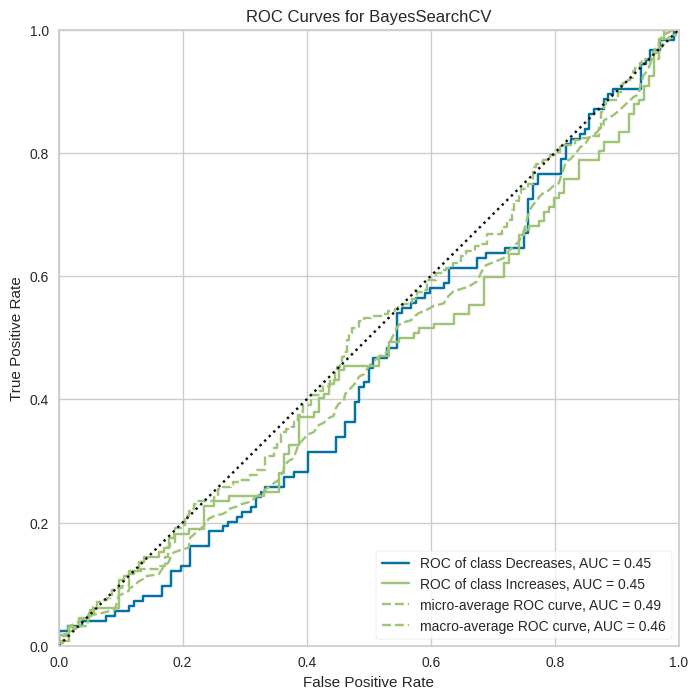

In [165]:
plt.figure(figsize=(8,8));
roc_auc(lrcBayes, windowTrainX, windowTrainY, windowTestX, windowTestY, classes=["Decreases", "Increases"]);

La curva de de ROC también se ajusta a la explicación dada anteriormente. Utilizaremos otros modelos y veremos si el problema encontrado aquí se llega a solucionar.

# Apartado C: MLP

In [166]:
mlp = MLPClassifier(max_iter=10000, early_stopping=True, n_iter_no_change=15, random_state=0)
print(np.mean(cross_val_score(mlp,windowTrainX,windowTrainY,cv=TimeSeriesSplit(n_splits=10, gap=w+1))))

0.5377777777777778


La validación cruzada para MLP sigue siendo igual de mala que en el apartado anterior.

In [167]:
param = {'activation':['relu',  'logistic'], 
         'alpha':[0.0001, 0.001, 0.01],
         'hidden_layer_sizes':[50, 100, 150, 200, 250], 
         'momentum': [0.7, 0.8, 0.9], 
         'learning_rate_init': [0.001, 0.01, 0.1],
         'n_iter_no_change':[30, 40, 50], 
         'learning_rate': ['constant', 'invscaling', 'adaptive']}

mlp =  MLPClassifier(max_iter=10000,early_stopping=True,random_state=0)
mlpBayes = BayesSearchCV(mlp,param,n_iter=15, 
                        cv=TimeSeriesSplit(n_splits=10, gap=w+1),
                        scoring=make_scorer(mean_squared_error, greater_is_better=False),
                        n_jobs=-1, 
                        refit=True, random_state=0)    
mlpBayes.fit(windowTrainX, windowTrainY);
show_html(pd.DataFrame(mlpBayes.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

BayesSearchCV(cv=TimeSeriesSplit(gap=4, max_train_size=None, n_splits=10, test_size=None),
              estimator=MLPClassifier(early_stopping=True, max_iter=10000,
                                      random_state=0),
              n_iter=15, n_jobs=-1, random_state=0,
              scoring=make_scorer(mean_squared_error, greater_is_better=False),
              search_spaces={'activation': ['relu', 'logistic'],
                             'alpha': [0.0001, 0.001, 0.01],
                             'hidden_layer_sizes': [50, 100, 150, 200, 250],
                             'learning_rate': ['constant', 'invscaling',
                                               'adaptive'],
                             'learning_rate_init': [0.001, 0.01, 0.1],
                             'momentum': [0.7, 0.8, 0.9],
                             'n_iter_no_change': [30, 40, 50]})

,params,mean_test_score,rank_test_score
12,"{'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 200, 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'momentum': 0.8, 'n_iter_no_change': 40}",-0.433333,1
4,"{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': 200, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'momentum': 0.8, 'n_iter_no_change': 30}",-0.434444,2
7,"{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 200, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'momentum': 0.7, 'n_iter_no_change': 30}",-0.444444,3
6,"{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 150, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'momentum': 0.9, 'n_iter_no_change': 40}",-0.447778,4
10,"{'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 150, 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'momentum': 0.8, 'n_iter_no_change': 30}",-0.452222,5


In [168]:
mean_squared_error(windowTestY,mlpBayes.predict(windowTestX)), mean_absolute_error(windowTestY,mlpBayes.predict(windowTestX))

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


(0.484375, 0.484375)

In [191]:
print(classification_report(mlpBayes.predict(windowTestX), windowTestY, target_names=["Decreases", "Increases"]))
results_df = save_results(mlpBayes, windowTestX, windowTestY, 'MLP Apartado C', results_df)

              precision    recall  f1-score   support

   Decreases       0.00      0.00      0.00         0
   Increases       1.00      0.52      0.68       256

    accuracy                           0.52       256
   macro avg       0.50      0.26      0.34       256
weighted avg       1.00      0.52      0.68       256



/home/mario/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mario/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mario/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mario/.local/lib/python3.10/site-packages/sklearn/metrics/

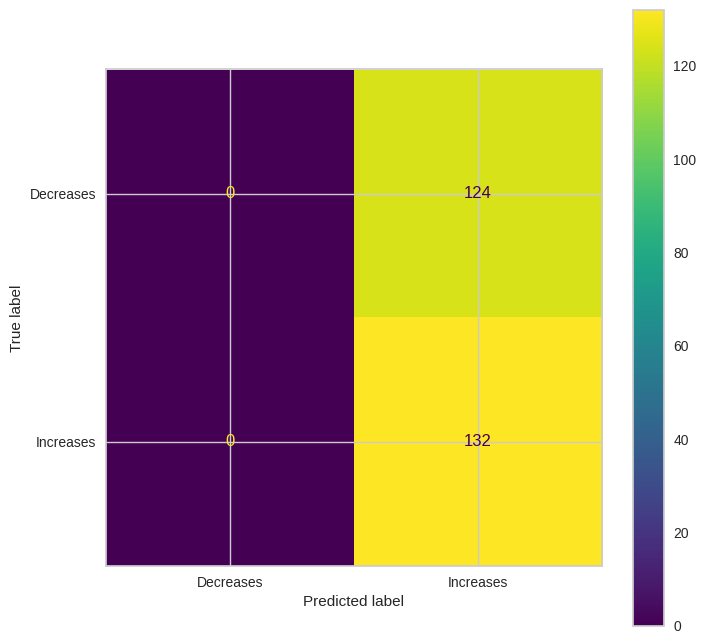

In [170]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(mlpBayes, windowTestX, windowTestY, display_labels=["Decreases", "Increases"], ax=plt.subplot());

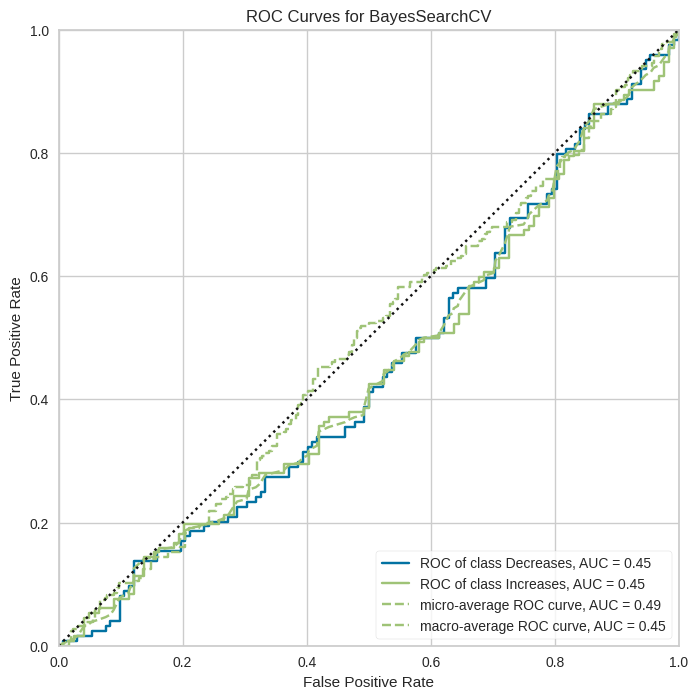

In [171]:
plt.figure(figsize=(8,8));
roc_auc(mlpBayes, windowTrainX, windowTrainY, windowTestX, windowTestY, classes=["Decreases", "Increases"]);

En general, vemos que los resultados son muy parecidos a los del apartado anterior. Se producen los mismos problemas y es que el modelo sigue diciendo que todos aumentan. Por los motivos comentados anteriormente, no considero que ninguno de los 2 modelos sea una buena opción para predecir lo que queremos. También cabe resaltar, que a priori en el analisis inicial parecía que las variables P si podían ser predichas, pero ha resultado que no. 

Por tanto, es necesario otro planteamiento si queremos predecir lo que nos propone el enunciado o quizás no se pueda.

# Apartado D

In [172]:
# nueva variable
googleV = data["GOOGLE-V"].values
targetV = [0]

for i in range(1, len(googleV)):
    targetV.append(1 if googleV[i] > googleV[i-1] else 0)

In [173]:
Vtra = np.array(targetV[w:1000])
VTes = np.array(targetV[1000+w:])

In [174]:
lrc_V = LogisticRegression(max_iter=1000)
print(np.mean(cross_val_score(lrc_V,windowTrainX,Vtra,cv=TimeSeriesSplit(n_splits=10, gap=w+1))))

0.6166666666666667


La validación cruzada vemos como tiene mejor pinta que en los apartados anteriores, a pesar, que sigue siendo baja.

In [175]:
param = {'penalty':['l2', 'none'], 'C':10**np.linspace(-3,3,50, endpoint=True)}
lrcVBayes =  BayesSearchCV(lrc_V, param, n_iter=15, cv=TimeSeriesSplit(n_splits=10, gap=w+1), n_jobs=-1, refit=True, random_state = 0);
lrcVBayes.fit(windowTrainX, Vtra);

/home/mario/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/mario/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mario/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/mario/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mario/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

/home/mario/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/mario/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mario/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/mario/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/mario/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

In [176]:
show_html(pd.DataFrame(lrcVBayes.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
13,"{'C': 138.9495494373136, 'penalty': 'l2'}",0.621111,1
11,"{'C': 429.1934260128778, 'penalty': 'l2'}",0.620000,2
0,"{'C': 1.5264179671752334, 'penalty': 'none'}",0.617778,3
1,"{'C': 0.03906939937054617, 'penalty': 'none'}",0.617778,3
3,"{'C': 0.0071968567300115215, 'penalty': 'none'}",0.617778,3


Vemos que los mejores parametros son C = 138.9 y penalty = l2. 

In [192]:
print(classification_report(lrcVBayes.predict(windowTestX), VTes, target_names=["Decreases", "Increases"]))
results_df = save_results(lrcVBayes, windowTestX, VTes, 'Clasifi Logistic', results_df)

              precision    recall  f1-score   support

   Decreases       0.75      0.58      0.65       179
   Increases       0.36      0.56      0.44        77

    accuracy                           0.57       256
   macro avg       0.56      0.57      0.55       256
weighted avg       0.63      0.57      0.59       256



Rápidamente, se aprecia donde ha habido la mejora y es que antes solo predecía incrementos. Ahora estos últimos ha bajado su precision, pero ha aumentado mucho el f1-score de los decrementos, lo cual, nos indica que seguramente esta nueva predicción a calcular sea más fácil.

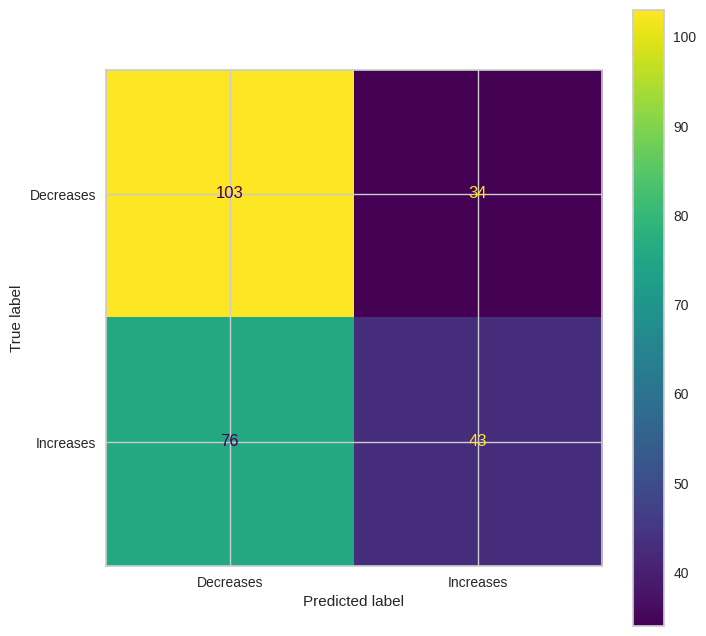

In [178]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lrcVBayes, windowTestX, VTes, display_labels=["Decreases", "Increases"], ax=plt.subplot());

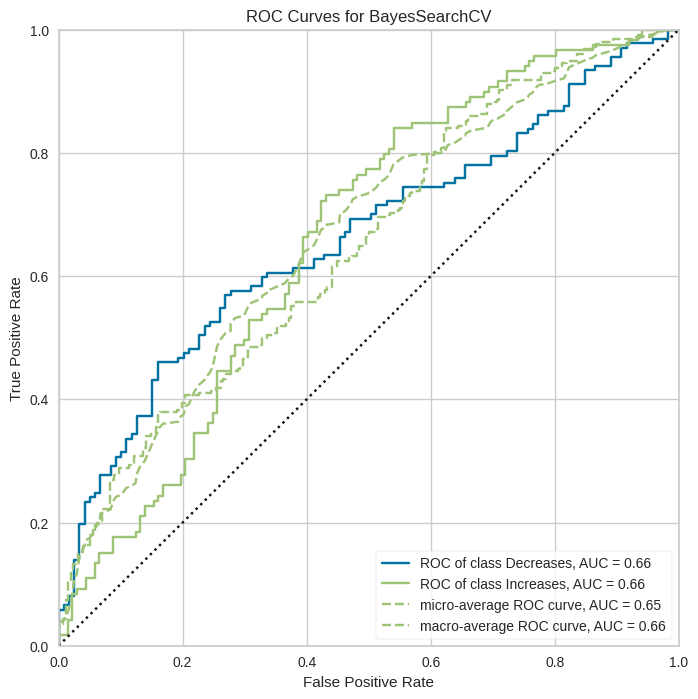

In [179]:
plt.figure(figsize=(8,8));
roc_auc(lrcVBayes, windowTrainX, Vtra, windowTestX, VTes, classes=["Decreases", "Increases"]);

El cambio es evidente en la Matriz de Confusión y en la curva de Roc. Pese a esta mejora, la predicción sigue teniendo resultados mediocres.

A continuación, probaremos con MLP.

In [180]:
mlp_V = MLPClassifier(max_iter=10000, early_stopping=True, random_state=0)
print(np.mean(cross_val_score(mlp_V,windowTrainX,Vtra,cv=TimeSeriesSplit(n_splits=10, gap=w+1))))

0.5577777777777777


La validación cruzada es peor que para clasificación logística.

In [181]:
param = {'activation':['relu',  'logistic'], 
         'alpha':[0.0001, 0.001, 0.01],
         'hidden_layer_sizes':[50, 100, 150, 200, 250], 
         'momentum': [0.7, 0.8, 0.9], 
         'learning_rate_init': [0.001, 0.01, 0.1],
         'n_iter_no_change':[20, 40, 60, 80], 
         'learning_rate': ['constant', 'invscaling', 'adaptive']}

mlpVBayes = BayesSearchCV(mlp_V,param,n_iter=15, 
                        cv=TimeSeriesSplit(n_splits=10, gap=w+1), 
                        scoring=make_scorer(mean_squared_error, greater_is_better=False),
                        n_jobs=-1, 
                        refit=True, random_state=0)    
mlpVBayes.fit(windowTrainX, Vtra);

In [182]:
show_html(pd.DataFrame(mlpVBayes.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
3,"{'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': 150, 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'momentum': 0.8, 'n_iter_no_change': 80}",-0.387778,1
10,"{'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': 150, 'learning_rate': 'invscaling', 'learning_rate_init': 0.1, 'momentum': 0.8, 'n_iter_no_change': 80}",-0.387778,1
11,"{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 150, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'momentum': 0.7, 'n_iter_no_change': 60}",-0.391111,3
0,"{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 150, 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'momentum': 0.9, 'n_iter_no_change': 20}",-0.403333,4
13,"{'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'momentum': 0.8, 'n_iter_no_change': 80}",-0.404444,5


In [183]:
mean_squared_error(VTes,mlpVBayes.predict(windowTestX)), mean_absolute_error(VTes,mlpVBayes.predict(windowTestX))

(0.44140625, 0.44140625)

In [193]:
print(classification_report(mlpVBayes.predict(windowTestX), VTes, target_names=["Decreases", "Increases"]))
results_df = save_results(mlpVBayes, windowTestX, VTes, 'MLP', results_df)

              precision    recall  f1-score   support

   Decreases       0.96      0.55      0.70       238
   Increases       0.10      0.67      0.18        18

    accuracy                           0.56       256
   macro avg       0.53      0.61      0.44       256
weighted avg       0.90      0.56      0.66       256



Para este caso, se obserba como ha mejorado mucho los valores para los decrementos, pero a costa de perder precision y f1-score en los incrementos.

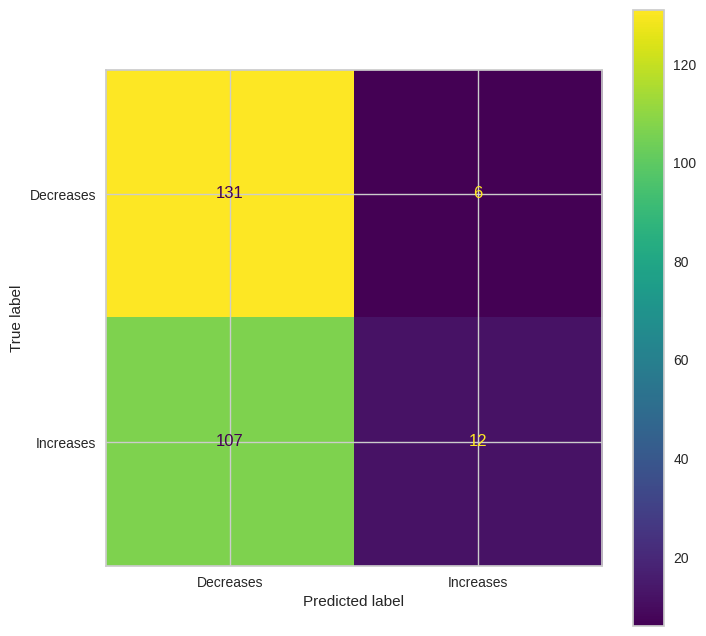

In [185]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(mlpVBayes, windowTestX, VTes, display_labels=["Decreases", "Increases"], ax=plt.subplot());

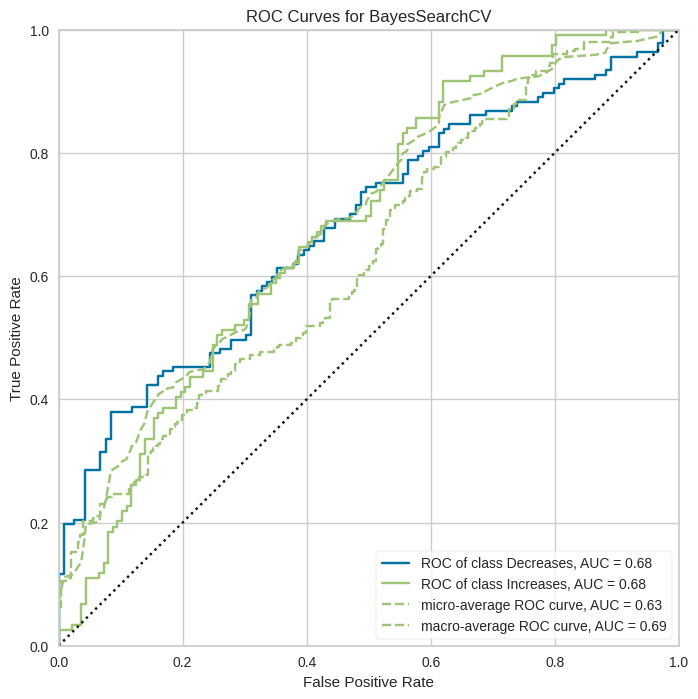

In [186]:
plt.figure(figsize=(8,8));
roc_auc(mlpVBayes, windowTrainX, Vtra, windowTestX, VTes, classes=["Decreases", "Increases"]);

Vemos en la Matriz de Confusión y en la curba de Roc nos confirman lo comentado anteriormente, el modelo es bastante bueno prediciendo decrementos pero un poco peor que para clasificación logísitca para predecir incrementos. 

In [194]:
results_df

,test acc,precision score (W),recall score (W),f1 score (W)
Logistic Apartado B,0.515625,0.265869,0.515625,0.350838
MLP Apartado C,0.515625,0.265869,0.515625,0.350838
Clasifi Logistic,0.570312,0.567527,0.570312,0.552830
MLP,0.558594,0.604457,0.558594,0.455328


Como conclusiones finales, podemos decir que lo que suponiamos en el primer apartado que las variables P serían más fáciles de predecir que las V era falso. La explicación para esto es lo que se ha comentado en el apartado B. El principal problema es que en los datos de entremiento los valores de P eran muy pequeños en comparación a los que había en los de test, esto acaba produciendo que el modelo no sea capaz de adaptarse correctamente y siempre acaba prediciendo un incremento.

Por otro lado, los valores de V parecen más constantes en el tiempo y esto ha facilitado que los modelos se adaptaran mejor obteniendo mejores resultados.